In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 2*x**2 + 6*x + 8

In [4]:
f(2)

28

In [5]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

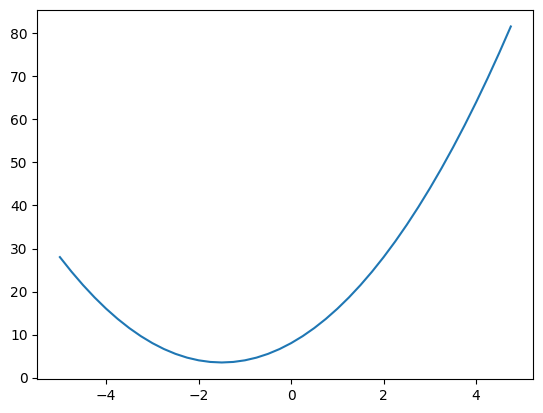

In [6]:
ys = f(xs)
plt.plot(xs, ys)

Numerical Derivative

In [34]:
h = 0.000001
x = -1.50009
der = (f(x+h)-f(x))/h
der

-0.0003580007401637886

Multivariate

In [35]:
a = 2
b = 3
c = 4

d = a*b + c

h = 0.0001

a+=h

der = (((a+h)*b + c) - (a*b +c))/h
der

3.000000000010772

In [36]:
der = (((b+h)*a + c) - (a*b +c))/h
der

2.000100000003613

In [37]:
der = ((a*b + c+h) - (a*b +c))/h
der

0.9999999999976694

Data structure to hold values

In [43]:
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data)
    
    def __mul__(self, other):
        return Value(self.data * other.data)

    
a = Value(2.0)
b = Value(3.0)
print(a, b)

print(a+b)

print(a*b)

Value(data=2.0) Value(data=3.0)
Value(data=5.0)
Value(data=6.0)


In [45]:
c = Value(4)

print(a*b + c)

Value(data=10.0)
